## 1. Import packages

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

## 2. Data Loading

In [2]:
PATH = os.getcwd()
CSV_PATH = os.path.join(PATH,"ecommerceDataset (2).csv")
df = pd.read_csv(CSV_PATH) 

## 3. Data inspection

In [31]:
print(df.info())
print("-"*20)
print(df.describe())
print("-"*20)
print(df.isna().sum())
print("-"*20)
print(df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 50423 entries, 0 to 50423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   50423 non-null  object
 1   text    50423 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB
None
--------------------
            label                                               text
count       50423                                              50423
unique          4                                              27801
top     Household  Think & Grow Rich About the Author NAPOLEON HI...
freq        19312                                                 30
--------------------
label    0
text     0
dtype: int64
--------------------
22622


In [4]:
#assigning the columns name
column_names = ['label','text']
df.columns = column_names

In [5]:
df.drop_duplicates()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50424 entries, 0 to 50423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   50424 non-null  object
 1   text    50423 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB
None


In [6]:
df.dropna(inplace=True)

In [7]:
df.isnull().sum()

label    0
text     0
dtype: int64

## 4. The review is the feature, the sentiment is the label

In [8]:
feature = df['text'].values
label = df['label'].values

## 5. Convert label into integers using LabelEncoder

In [9]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_processed = label_encoder.fit_transform(label)

## 6. Data preprocessing

In [10]:
#import re

#def remove_unwanted_strings(review):
    #for index, data in enumerate(review):
        #review[index] = re.sub('<.*?>', ' ', data) 
        #eview[index] = re.sub('[^a-zA-Z]',' ',data).lower().split()
    #return review
#feature_removed = remove_unwanted_strings(feature)

## 7. Define some hyperparameter

In [11]:
vocab_size = 5000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = 0.8

## 8. Perform train test split

In [12]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(feature,label_processed,train_size=training_portion,random_state=12345)

## 9. Perform tokenization

In [13]:
from tensorflow import keras

tokenizer = keras.preprocessing.text.Tokenizer(num_words=vocab_size,split=" ",oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

In [14]:
word_index = tokenizer.word_index
print(dict(list(word_index.items())[0:10]))

X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

{'<OOV>': 1, 'the': 2, 'and': 3, 'of': 4, 'to': 5, 'a': 6, 'for': 7, 'in': 8, 'with': 9, 'is': 10}


## 10. Perform padding and truncating

In [15]:
X_train_padded = keras.preprocessing.sequence.pad_sequences(X_train_tokens,maxlen=(max_length))
X_test_padded = keras.preprocessing.sequence.pad_sequences(X_test_tokens,maxlen=(max_length))

## 11. Model development

In [16]:
#(A) Create the sequential model
model = keras.Sequential()
#(B) Create the input layer, in this case, it can be the embedding layer
model.add(keras.layers.Embedding(vocab_size,embedding_dim))
#(B) Create the bidirectional LSTM layer
model.add(keras.layers.Bidirectional(keras.layers.LSTM(embedding_dim)))
#(C) Classification layers
model.add(keras.layers.Dense(embedding_dim,activation='relu'))
model.add(keras.layers.Dense(len(np.unique(y_train)),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 394,564
Trainable params: 394,564
Non-trainable params: 0
_________________________________________________________________


## 12. Model Compilation

In [17]:
#Create a TensorBoard callback object for the usage of TensorBoard
import tensorflow as tf
import datetime
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import TensorBoard
base_log_path = r"tensorboard_logs\capstone_assignment_2"
log_path = os.path.join(base_log_path,datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb = callbacks.TensorBoard(log_path)

In [19]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

## 13. Model training

In [20]:
import numpy as np
from sklearn.metrics import f1_score

# Train the model
history = model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=5, batch_size=64, callbacks=[tb])

# Make predictions on the test set
y_pred = model.predict(X_test_padded)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred_labels, average='weighted')

# Print the F1 score
print("F1 Score:", f1)


Epoch 1/5
631/631 [==============================] - 169s 259ms/step - loss: 0.4974 - accuracy: 0.8186 - val_loss: 0.2281 - val_accuracy: 0.9406
Epoch 2/5
631/631 [==============================] - 166s 262ms/step - loss: 0.2181 - accuracy: 0.9379 - val_loss: 0.1824 - val_accuracy: 0.9525
Epoch 3/5
631/631 [==============================] - 166s 264ms/step - loss: 0.1388 - accuracy: 0.9642 - val_loss: 0.1469 - val_accuracy: 0.9628
Epoch 4/5
631/631 [==============================] - 163s 258ms/step - loss: 0.1110 - accuracy: 0.9725 - val_loss: 0.1501 - val_accuracy: 0.9641
Epoch 5/5
316/316 [==============================] - 13s 38ms/step
F1 Score: 0.9594564278688331


## 14. Model Evaluation

In [21]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


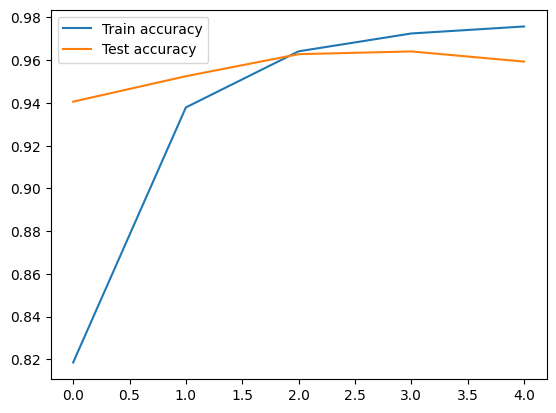

In [22]:
#Plot accuracy graphs
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(["Train accuracy","Test accuracy"])
plt.show()

In [23]:
test_string = ['tulis je apa2','tulis je apa']
test_string_tokens = tokenizer.texts_to_sequences(test_string)
test_string_padded = keras.preprocessing.sequence.pad_sequences(test_string_tokens,maxlen=(max_length))
y_pred = np.argmax(model.predict(test_string_padded),axis=1)

1/1 [==============================] - 0s 72ms/step


In [24]:
label_map = ['Books','Clothing & Accessories','Electronics','Household']
predicted_sentiment = [label_map[i] for i in y_pred]

In [25]:

PATH = os.getcwd()
print(PATH)

c:\Users\syami\Desktop\HANDS-ON\Assessment_2


In [26]:
#Model save path
model_save_path = os.path.join(PATH,"saved_models")
keras.models.save_model(model,model_save_path)

INFO:tensorflow:Assets written to: c:\Users\syami\Desktop\HANDS-ON\Assessment_2\saved_models\assets


INFO:tensorflow:Assets written to: c:\Users\syami\Desktop\HANDS-ON\Assessment_2\saved_models\assets


In [27]:
#Check if the model can be loaded
model_loaded = keras.models.load_model(model_save_path)

In [28]:
# Create the folder if it doesn't exist
os.makedirs(model_save_path, exist_ok=True)

# Save the model in .h5 format
model_path = os.path.join(model_save_path, 'model.h5')
model.save(model_path)

In [29]:
#tokenizer save path
import pickle

tokenizer_save_path = os.path.join(PATH,"tokenizer.pkl")
with open(tokenizer_save_path,'wb') as f:
    pickle.dump(tokenizer,f)

In [30]:
#Check if the tokenizer object can be loaded
with open(tokenizer_save_path,'rb') as f:
    tokenizer_loaded = pickle.load(f)